#  Training an MLP from scratch

**Nom** : Senhadji M Said

# Necessary Packages


In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1- Initialization
Write the function ``init_params(nx, nh, ny)``

In [32]:
def init_params(nx, nh, ny): 
    W1 = np.random.normal(loc=0, scale=0.3, size=(nh, nx+1)).astype(np.float32)
    W2 = np.random.normal(loc=0, scale=0.3, size=(ny, nh+1)).astype(np.float32)
    return [W1, W2]

## Forward propagation

### Activation Functions:
- `tanh(z)` : Hyperbolic tangent activation function
- `sigmoid(z)` : Standard sigmoid function
- `softmax(z)` : Converts logits into probabilities, with a numerical stability trick `z.max(axis=0)` to prevent overflow.
 

In [33]:
def tanh(z):
    return np.tanh(z)


In [34]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [35]:
def softmax(z):
    t = np.exp(z - np.max(z, axis=0, keepdims=True))  
    return t / np.sum(t, axis=0, keepdims=True)

### `forward` function
1. **inputs**:
   - `params` : List of wight matrices for each layer.
   - `X`: Input data of shape `(n_batch, nx)`
   - `activation`: List of activation functions to be used for each layer
2. **Processing**: 
   - The input `X` is transposed `(Y = X.T)` to match matrix multiplication dimensions.
   - The function loops through each weight matrix (`W`) and activation function (`activation`).
   - **Bias Handling**: Adds a row of ones to Y to account for bias terms.
   - Computes `Z = W @ Y` (weighted sum).
   - Applies the activation function : `Y = activation(Z)`.
   - Stores both `Z` (pre-activation) and `Y` (post-activation) in `outputs`.
3. **Returns**: 
   - `outputs`: A list of intermediate values, as dictionaries `({"Z": Z, "Y": Y})`.

In [36]:
def forward(params, X, activations):
    Y = X.T  
    outputs = []

    for W, activation in zip(params, activations):
        Y = np.vstack([np.ones((1, Y.shape[1])), Y])  
        Z = W @ Y  
        Y = activation(Z)  
        outputs.append([Z, Y])  

    return outputs

## Loss & Accuracy
### Loss Calculation (Categorical Cross-Entropy)
For multi-class classification, we typically use categorical cross-entropy loss, which is defined as:
$$ L = - \frac{1}{N} \sum_{i=1}^{N}{\sum_{j=1}^{C}{y_{i,j}log(\hat{y}_{i,j})}}  $$
where:
  - $N$ is the number of samples.
  - $C$ is the number of classes.
  - $y_{i,j}$ is the actual label for sample $i$, class $j$.
  - $\hat{y}_{i,j}$ is the predicted probability for sample $i$, class $j$.

### Accuracy Calculation
$$ \text{Accurancy} = \frac{1}{N}\sum_{i=1}^N{1(\arg \max{\hat{y_i}} = \arg \max{y_i})} $$
where: 
- $\arg \max{y_i}$ : finds the index of the correct class (ground truth label)
- $\arg \max{\hat{y_i}}$ : finds the index of the predicted class
- $1(.)$ : s an indicator function that returns $1$ if the predicted class matches the true class, otherwise $0$.


In [37]:
def loss_accuracy(y_hat, y):
    loss = -np.mean(np.log(np.sum(y_hat * y, axis=1)))
    accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y, axis=1))
    return loss,accuracy

## Backward propagation
**Inputs**: 
  - `X`: Input data of shape $(m, nx)$
  - `params`: List of weight matrices ``
  - `outputs`: List of forward pass outputs `[[Z1, A1], [Z2, A2]]`
  - `Y`:   Ground truth labels

**Step 1: Preparing Activations**
- Adds a bias row (ones) to `A1` and `X` to match dimensions with weight matrices.
- `outputs[-2][1]` refers to `A1`, the activation from the hidden layer.

**Step 2: Compute Gradients for Output Layer**
- Computes the output layer error
  $$ dZ^{[2]} = \hat{Y} - Y $$
- Computes the gradient for `W2`: 
  $$ dW^{[2]} = dZ^{[2]}.A^{[1]T} $$ 

**Step 3: Compute Gradients for Hidden Layer**
- ``outputs[-2][0]`` refers to Z1, the pre-activation of the hidden layer.
- Applies the tanh function to retrieve `A1` for the derivative.
  $$ dZ^{[1]} = (W^{[2]T} \cdot dZ^{[2]}) * (1 - {A^{[1]}}^2) $$ 

**Step 4: Compute Gradients for First Layer**
Computes 
$$ dW^{[1]} = dZ^{[1]} \cdot X^T $$

**Final Return**
```python
return gradients

```

In [38]:
def backward(X, params, outputs, Y):
    print(outputs)
    # step 1
    outputs[-2][1] = np.vstack([np.ones(outputs[-2][1].shape[1]),outputs[-2][1]]) # dA
    X = np.vstack([np.ones(X.shape[0]),X.T])

    # step 2
    gradients = {}

    gradients["dZ2"] = outputs[-1][1] - Y.T # (ny,m) - (ny,m) = (ny,m)
    gradients["dW2"] = gradients["dZ2"] @ outputs[-2][1].T # (ny,m) * (m,nh+1) = (ny,nh+1)
    
	# step 3
    t = tanh(outputs[-2][0]) # (nh,m)
    gradients["dZ1"] = (params[-1].T[1:] @ gradients["dZ2"]) * (1 - t ** 2) 
    # (nh,ny) @ (ny,m) * (nh,m) = (nh,m)
    # step 4
    gradients["dW1"] = gradients["dZ1"] @ X.T 
    # (nh,m) @ (m,nx+1) = (nh,nx+1)

    return gradients

## Gradient Descent
**Stochastic Gradient Descent** (SGD) updates the parameters using the formula:
$$ W = W - \eta \cdot \nabla W $$ 
where:
- $ W $ are the weight matrices (`params`)
- $ \eta $  is the learning rate (`eta`)
- $ \nabla W $  are the computed gradients (`grads`)

In [39]:
def sgd(params, grads, eta):
    params[0] = params[0] - eta * grads["dW1"]
    params[1] = params[1] - eta * grads["dW2"]

## Train


### utility functions

In [40]:
def one_hot(a):
    b = np.zeros((a.size, a.max() + 1))
    b[np.arange(a.size), a] = 1
    return b

In [41]:
def predict(params, X):
    outputs = forward(params, X, [tanh,softmax])
    y_hat = outputs[-1][-1]
    y_hat = np.argmax(y_hat, axis=0)
    return y_hat

In [42]:
def add_eps(params, eps=10e-4):
    result = []

    for param in params:
        result.append(param + eps)

    return result

### Train function

In [43]:
from tqdm.notebook import trange

def train(X, Y, test_set=None,eta=0.01, epochs=50, batch_size=128, nh=32):
    #  1 setup & initi
    m,n = X.shape

    ny = len(np.unique(Y))

    Y = one_hot(Y)

    if test_set is not None:
        test_set = (test_set[0], one_hot(test_set[1]))

    params = init_params(n,nh,ny)

    # 2 Initialize History
    history = {
        "accuracy": [],
        "loss":[],
        "test loss":[],
        "test accuracy":[]
    }

    real_grads = []
    approx_grads = []
    
	# 3 Training Loop
    for j in range(epochs):
        idx = np.arange(m)
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

        batches_count = int(np.floor(m / batch_size))
        # 4 mini-batch processing
        t = trange(batches_count, desc='Bar desc', leave=True)
        
        for i in t:
            
            X_batch = X[i * batch_size:(i+1) * batch_size,:]
            Y_batch = Y[i * batch_size:(i+1) * batch_size,:]

            outputs = forward(params, X_batch, [tanh, softmax])
            grads = backward(X_batch, params, outputs, Y_batch)

            # 5 gradient approximation
            outputs_p_eps = forward(add_eps(params, 10e-4), X_batch, [tanh, softmax])[-1][-1]
            outputs_m_eps = forward(add_eps(params, -10e-4), X_batch, [tanh, softmax])[-1][-1]
            approx_grad = (outputs_m_eps-outputs_p_eps) / (2 * 10e-4)
            
            # 6 update parametes using SGD
            real_grads.append(grads)
            approx_grads.append(approx_grad)
            
            sgd(params, grads,eta=eta)

            # 7 compute metrics
            if i % 50 == 0:
                Y_hat = outputs[-1][1].T
                loss, accuracy = loss_accuracy(Y_hat, Y_batch)

                msg = f"epoch = {j+1} | loss = {loss:.6f} | accuracy = {100 * accuracy:.2f}%"
                test_loss,test_accuracy = None,None

                if test_set is not None:
                    X_test,y_test = test_set
                    y_test_hat = forward(params, X_test, [tanh, softmax])[-1][1].T
                    test_loss, test_accuracy = loss_accuracy(y_test, y_test_hat)
                    msg += f" | test loss = {test_loss:.6f} | test accuracy = {100 * test_accuracy:.2f}%"
    
                if i % 50 == 0:
                    t.set_description(msg)
                    t.refresh()
                
				# 8 Store History
                history["loss"].append(loss)
                history["accuracy"].append(accuracy)
        
                if test_set is not None:
                    history["test loss"].append(test_loss)
                    history["test accuracy"].append(test_accuracy)
    return params,history,real_grads,approx_grads


#### Quick Breakdown of the Code
1. **Setup & Initialization**
   - Converts labels to one-hot encoding.
   - Intializes parameters (`W1, W2`)
   - Stores test data (if provided).
2. **Initialize History for Tracking Metrics**
   - `history`: Tracks loss and accuracy for training & test sets
   - `real_grads`: Stores actual gradients from backpropagation.
   - `approx_grads`: Stores numerical gradient approximations.
3. **Training Loop**
   - Shuffles data each epoch for better generalization.
   - Divides data into mini-batches.
4. **Mini-Batch Processing**
   - Iterates over mini-batches.
   - Performs forward pass to compute predictions.
   - Computes gradients using backpropagation.
5. **Gradient Approximation for Debugging**
   - Computes numerical gradients using **finite difference approximation**:
   $$ \frac{f(x+\epsilon) - f(x-\epsilon)}{2 \epsilon}  $$
   - Compares backpropagation gradients vs. numerical gradients.
6. **Update Parameters Using SGD**
   - Stores real gradients.
   - Stores approximated gradients for debugging.
7. **Compute Metrics**
   - Computes **loss & accuracy** for training batch.
   - If test data is available, computes test loss & accuracy.
   - Displays progress bar updates in real time.
8. **Store History**
   - Saves training & test metrics for plotting later.

## Graphing Accuracy & Loss

In [44]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Train Loss")
    if "test loss" in history:
        plt.plot(history["test loss"], label="Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Time")

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["accuracy"], label="Train Accuracy")
    if "test accuracy" in history:
        plt.plot(history["test accuracy"], label="Test Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Time")

    plt.show()

# Call function after training

## Train on mnist handwritten digits
### Load the dataset

- **Dataset link** : https://www.kaggle.com/datasets/hojjatk/mnist-dataset/code?datasetId=102285&searchQuery=MLP

In [45]:
df = pd.read_csv("./data/mnist_train.csv")


In [46]:
Y = df["label"].values
X = df[df.columns[1:]].values

<Axes: ylabel='count'>

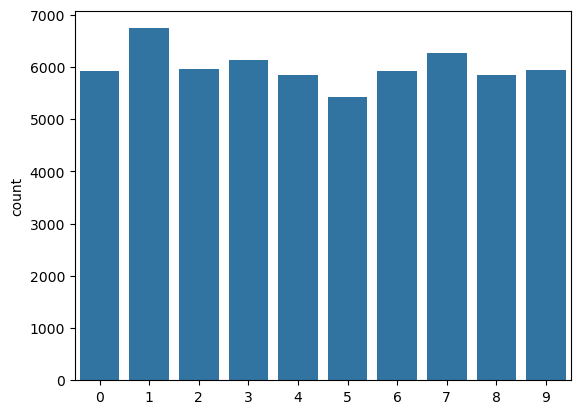

In [47]:
sns.countplot(x=Y)

### Show some images

In [49]:
def plot_random_images(X,Y, nrows=3, ncols=3, real_lables = None):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    n = nrows * ncols

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    idx = idx[:n]

    X = X[idx]
    Y = Y[idx]

    if real_lables is not None:
        real_lables = real_lables[idx]
    
    i = 0
    for row in axes:
        for cell in row:
            img = X[i].reshape(28,28)
            cell.imshow(img,cmap="gray")
            if real_lables is None:
                cell.set_title(f"Label = {Y[i]}")
            else:
                cell.set_title(f"Label = {Y[i]} \n Real Label = {real_lables[i]}")
            i += 1

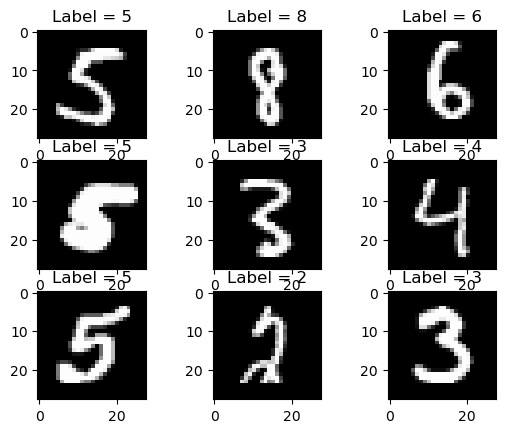

In [50]:
plot_random_images(X,Y)

In [51]:
X = X / 255.0

In [52]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.2,stratify=Y)

In [53]:
params,history = train(
    X_train, 
    y_train, 
    test_set=(X_test,y_test),
    eta=0.01, 
    epochs=50,
    batch_size=128,
    nh=64
)

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

[[array([[ -1.11054609,   2.77945051,   0.21704994, ...,  -2.61226447,
          2.24569486,   1.49939439],
       [  3.79981197,   1.46236581,   0.61993889, ...,   2.61459833,
         -1.38023327,   2.15084213],
       [ -2.33534909,  -1.78296649,  -3.06448578, ...,  -2.44420561,
         -3.06081723,  -1.64204636],
       ...,
       [ -4.02305353,  -8.00582042,  -5.13566532, ...,  -5.97027791,
         -5.2468808 ,  -1.64877545],
       [ -5.10708976, -10.93631944,  -6.83769441, ...,  -6.06880589,
        -11.80390426,  -0.58372781],
       [ -4.29077391,   1.75893213,  -1.4472823 , ...,  -0.95101749,
          3.30452625,  -0.16112333]]), array([[-0.80425534,  0.99232356,  0.21370451, ..., -0.98929185,
         0.9778382 ,  0.90503876],
       [ 0.99899922,  0.89811111,  0.55108548, ...,  0.98934145,
        -0.88100349,  0.97327062],
       [-0.98144235, -0.94501331, -0.99565183, ..., -0.98504589,
        -0.99561988, -0.92775809],
       ...,
       [-0.99935951, -0.99999978, -0

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

[[array([[-0.20471999,  4.89120871,  0.31499535, ..., -2.95121325,
         1.36493134,  0.49814896],
       [ 1.11371104,  9.10728854,  3.66876569, ..., -0.50372417,
         6.05974494,  2.4710915 ],
       [-3.69245254, -6.48555063, -3.10335546, ..., -7.49717512,
        -6.85682435, -7.1530957 ],
       ...,
       [-6.40234907, -9.68986835, -4.42318775, ..., -2.35868448,
        -6.98398506, -5.82785926],
       [-5.93856532,  0.25670782,  1.77669557, ...,  2.11561778,
         1.89369468, -2.31787892],
       [ 2.86600252,  6.90643485,  2.86701664, ...,  4.46252212,
         8.61599861, -0.69139223]]), array([[-0.20190718,  0.99988714,  0.30497471, ..., -0.99454928,
         0.87753189,  0.46066017],
       [ 0.80537027,  0.99999998,  0.99869954, ..., -0.46504098,
         0.9999891 ,  0.98582321],
       [-0.99875967, -0.99999535, -0.9959764 , ..., -0.99999938,
        -0.99999779, -0.99999878],
       ...,
       [-0.9999945 , -0.99999999, -0.99971224, ..., -0.98228105,
       

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

[[array([[ -2.1474932 ,   0.9349923 ,   1.42471324, ...,  -4.25099116,
         -1.86346552,   0.52503655],
       [  2.52311724,   8.64751726,   9.73706099, ...,   2.58448651,
          5.2462084 ,   3.25487725],
       [ -2.97507319,  -4.1273895 , -10.19561173, ...,  -2.88568806,
         -5.07874257,  -5.129749  ],
       ...,
       [ -1.16781656,  -2.55909435,  -2.78793793, ...,  -1.75432641,
         -4.46249457,  -6.88189966],
       [  6.51422212,   2.4711679 ,  -3.30891929, ...,   5.36160476,
         -4.35132952,   1.87101242],
       [  0.31784912,  -5.72562169,   3.05938097, ...,   1.64492344,
         -5.49495376,   5.81901438]]), array([[-0.9730934 ,  0.73291299,  0.89057806, ..., -0.99959395,
        -0.95299801,  0.48157787],
       [ 0.98721522,  0.99999994,  0.99999999, ...,  0.98868358,
         0.99994451,  0.99702674],
       [-0.99480262, -0.99948011, -1.        , ..., -0.99378842,
        -0.99992243, -0.99992996],
       ...,
       [-0.82357095, -0.98809754, -0

KeyboardInterrupt: 